# Loan Default Predictive Model: Data Munging and Exploration

In this blog post, I will be utilizing publicly available Lending Club loans' data to build a model to predict loan default. In the process, I will be demonstrating various techniques for data munging, data exploration, feature selection, model building  based on  several Machine Learning algorithms, and model evaluation to meet specific project goals.

### About Lending Club

LendingClub.com is a company that matches individual investors hoping to make good returns on an investment with borrowers looking for personal unsecured loans with reasonable fixed rates. It bills itself as "America's #1 credit marketplace" and is currently the largest peer-to-peer lending platform in the world. To request a loan, an individual completes an exhaustive application online. The application is then assessed for risk and awarded a grade ranging from A to G with G being the more risky ones. The grade awarded also determines the interest rate on the loan. Once approved, the loan is listed and investors can then browse loan listings and select loans to fund based on information on the borrower.

### Goal

For this project, I will be aiming to build a predictive model that will allow an investor to make well informed decisions on what loans to invest in so as to maximize on returns. Since the goal is to ensure that we avoid loan defaults, it is of paramount importance that I avoid misclassifying bad loans as good (a classification of a good loan as bad, while reducing the potential pool for investment, will not have the same ramifications). 

### A Note on the Data

Data was obtained from the Lending Club website at https://www.lendingclub.com/info/download-data.action. For the analysis, I will be combining two sets of data, from 2007-2011 (9.64 Mb) and from 2012-2013 (37 Mb)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn.apionly as sns
import cPickle

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

<br>
## Data Preparation and Exploratory Data Analysis

**Obtain the data and load it into a dataframe. I will be combining data from 2007 to 2013 to ensure I have enough data. The 2007-2011 data set has 42538 entries while the 2012 to 2013 data set consists of 188125 entries.**

In [ ]:
df_0 = pd.read_csv("/home/concinte/Code/LoanDefault/Data/LoanStats3a.csv",skiprows=1,low_memory=False)
df_0.head(2)
df_0.to_pickle('df_20072011.pkl')

In [ ]:
df_0.info()

In [ ]:
df_1 = pd.read_csv("/home/concinte/Code/LoanDefault/Data/LoanStats3b.csv",skiprows=1,low_memory=False)
df_1.head(2)
df_1.to_pickle('df_20122013.pkl')

In [ ]:
df_1.info()

<br>
**Combine the two dataframes to get one large dataset and pickle to reduce loading time**

In [ ]:
df_0 = pd.read_pickle('df_20072011.pkl')
df_1 = pd.read_pickle('df_20122013.pkl')

In [ ]:
df = pd.concat([df_0, df_1])

<br>
**Detailed Information on the columns**

In [ ]:
df.info(verbose=False, null_counts=True)

I will need to go through the individual columns and drop those that have a lot of NA's, and those columns that will not be useful in building a model

<br>
### Drop columns that are not useful


**Drop columns with all None values**

In [ ]:
df.drop(df.columns[80:105], axis=1, inplace=True)
df.drop(df.columns[57:78], axis=1, inplace=True)
df.drop(df.columns[61:65], axis=1, inplace=True)
df.drop(df.columns[53:56], axis=1, inplace=True)
df.drop(df.columns[50], axis=1, inplace=True)

<br>
**Drop columns with more than 90 % None values**

In [ ]:
df.drop('next_pymnt_d', axis=1, inplace=True)   
df.drop('mths_since_last_record', axis=1, inplace=True) 

<br>
**Drop column labeled "application_type" since it has all the same value**

In [ ]:
df.drop('application_type', axis=1, inplace=True) 

<br>
**Drop columns that I deem unnecessary**

In [ ]:
df.drop(['url', 'emp_title', 'zip_code'], axis=1, inplace=True) 

<br>
**Pickle the semi-processed dataframe to use as a launch point**

In [ ]:
df.to_pickle('df_combinedSemiProcessed.pkl')

<br>
**<font color='red'> Launch off point for convenience due to memory limitations</font>**

In [4]:
df = pd.read_pickle('df_combinedSemiProcessed.pkl')

<br>
**The columns labeled 'collections_12_mths_ex_med', 'chargeoff_within_12_mths', and 'tax_liens' have almost all values as either None or 0 and will therefore not be very useful for modeling. Remove them.**

In [5]:
len(df[df['collections_12_mths_ex_med']==0]), df['collections_12_mths_ex_med'].isnull().sum(),
len(df[df['collections_12_mths_ex_med']>0])

568

In [6]:
len(df[df['chargeoff_within_12_mths']==0]), df['chargeoff_within_12_mths'].isnull().sum(),
len(df[df['chargeoff_within_12_mths']>0])

874

In [7]:
len(df[df['tax_liens']==0]), df['tax_liens'].isnull().sum(), len(df[df['tax_liens']>0])

(228902, 110, 1651)

In [8]:
df.drop(['collections_12_mths_ex_med','chargeoff_within_12_mths','tax_liens'], axis=1, inplace=True) 

<br>
**Columns labeled 'id' and 'member_id' will not contribute to the model. Remove them.**

In [9]:
df.drop(['id','member_id'], axis=1, inplace=True) 

<br>
**Some features contain information that was not available at the time of loan application. I cannot use this in the predictive model. Remove them.**

In [10]:
df.drop(['out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int',
        'total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt',
        'last_credit_pull_d'], axis=1, inplace=True) 

<br>
**The column 'pymnt_plan' does not provide any additional information beyond what we can extract from other columns. In addition, it contains classes that are heavily imbalanced and will therefore not be of any use in building a predictive model. Remove it.**

In [11]:
df.pymnt_plan.value_counts()
df.drop(['pymnt_plan'], axis=1, inplace=True)

<br>
**The columns 'policy_code' and 'initial_list_status' also have only one class and do not provide any information that would be useful in building a predictive model. Remove them.**

In [12]:
df.policy_code.value_counts()
df.initial_list_status.value_counts()
df.drop(['policy_code', 'initial_list_status'], axis=1, inplace=True)

<br>
**The column 'title' is a brief description of what the loan is intended for. It would be very interesting to group the various descriptions into classes for semantic analysis and maybe use the results as a feature in a predictive model, but that will be for another time. I will therefore remove it too.**

In [13]:
df.drop(['title'], axis=1, inplace=True)

<br>
**The 'desc' column allows a borrower to provide more detail on why they need the loan. This would also be another very interesting column for semantic analysis, but is not necessary for the purposes of the current predictive model. Remove it**

In [14]:
df.drop(['desc'], axis=1, inplace=True)

<br>
** The 'grade' and 'sub_grade' columns are based on Lending Club's (LC) assessment of a borrower's credit worth. I will not use them in the predictive model but would nevertheless like to compare the results of the predictive model with LC's assessment. Before removing them from the data frame, it is interesting to see how the grades correlate to the default rate. Here are some plots showing the distribution of grades, and loan status**

Populating the interactive namespace from numpy and matplotlib


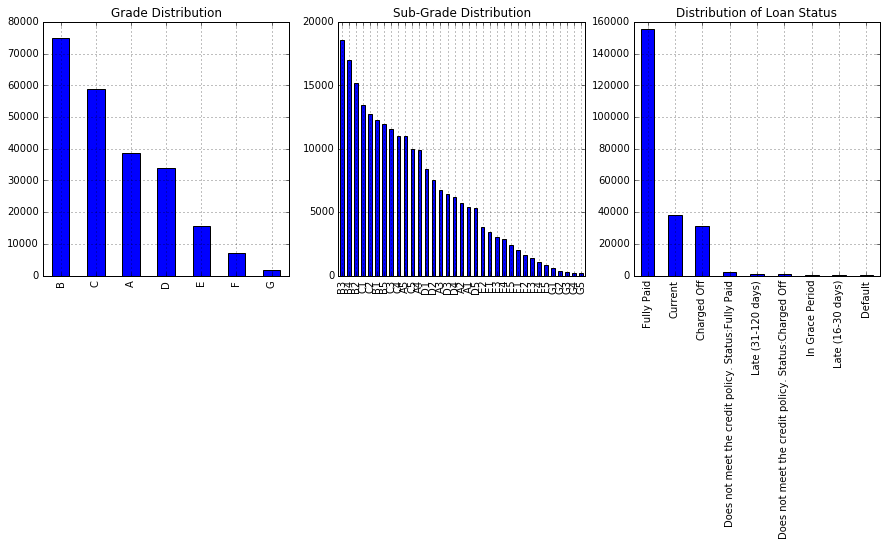

In [15]:
%pylab inline

fig = plt.figure(figsize=(15,10))

plt.subplot2grid((2,3), (0,0))
df['grade'].value_counts().plot(kind='bar',title='Grade Distribution')
plt.grid(True)

plt.subplot2grid((2,3), (0,1))
df['sub_grade'].value_counts().plot(kind='bar',title='Sub-Grade Distribution')
plt.grid(True)

plt.subplot2grid((2,3), (0,2))
df['loan_status'].value_counts().plot(kind='bar',title='Distribution of Loan Status')
plt.grid(True)

From the grade and sub grade distributions, we see that most loans tend to have a higher grade, meaning a more creditworthy rating. We can also see from the loan status plot that, as you would expect, an overwhelming majority of the loans are good loans.

In [16]:
df.loan_status.value_counts()

Fully Paid                                             155826
Current                                                 38420
Charged Off                                             31383
Does not meet the credit policy. Status:Fully Paid       1988
Late (31-120 days)                                       1218
Does not meet the credit policy. Status:Charged Off       761
In Grace Period                                           636
Late (16-30 days)                                         344
Default                                                    82
Name: loan_status, dtype: int64

**The intention of this analysis is to maximize on returns meaning that the precision with which we determine those loans that will default and those that will provide full repayment is of paramount importance. With the model we build, it is more excusable to mislabel a good loan as bad than to mislabel a bad loan as good. For this reason, we will binarize the target column 'loan_status' selecting only for those loan that we know with near absolute certainity the outcome. The negative class will consist of 'Fully Paid', and 'Does not meet the credit policy. Status:Fully Paid' while the positive class will be made up of 'Charged Off', 'Does not meet the credit policy. Status:Charged Off', and 'Default'. According to the Lending Club, 'Does not meet the credit policy. Status: <>' are all those loans that were approved before a change in credit policy. With regard to Charged Off and defaults, a loan is considered a default if it has gone for more than 120 days with no payment. It is then be charged off not more that 30 days later**

In [17]:
df_negClass = df[df['loan_status'].isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid'])]

In [18]:
df_posClass = df[df['loan_status'].isin(['Charged Off', 
                                         'Does not meet the credit policy. Status:Charged Off', 'Default'])]

**Combine the two data frames, binarize the 'loan_status' column, and shuffle**

In [19]:
df = pd.concat([df_negClass, df_posClass])

**The new dataframe has duplicated indices. Reset**

In [20]:
df = df.reset_index(drop=True)

**Binarize the 'loan_status' column by creating new column 'loan_status_binary'**

In [21]:
df['loan_status_binary'] = (~df.loan_status.isin(['Fully Paid', 
                                                  'Does not meet the credit policy. Status:Fully Paid',
                                                 ])).astype(int)

**Shuffle the data frame**

In [22]:
df = df.reindex(np.random.permutation(df.index))

**Reset index again after shuffle**

In [23]:
df = df.reset_index(drop=True)

In [24]:
df.loan_status_binary.value_counts()

0    157814
1     32226
Name: loan_status_binary, dtype: int64

<br>
### Create a stacked histogram for good and bad loans for each grade

In [25]:
loan_status = pd.crosstab(df.grade, df.loan_status_binary)

**Normalize cross tab**

In [26]:
loan_status = loan_status.div(loan_status.sum(1).astype(float),axis=0)
loan_status

loan_status_binary,0,1
grade,,
A,0.938362,0.061638
B,0.876072,0.123928
C,0.805657,0.194343
D,0.751667,0.248333
E,0.676165,0.323835
F,0.608290,0.391710
G,0.595087,0.404913


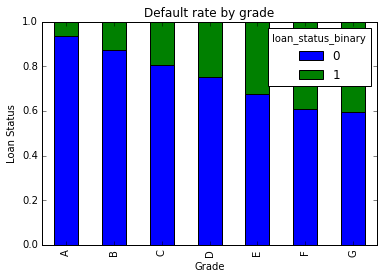

In [27]:
#Stacked histogram
loan_status.plot(kind='bar', stacked=True, title='Default rate by grade')
plt.xlabel('Grade')
plt.ylabel('Loan Status')

As expected, the default rate increases as you move to the more riskier grades

<br>
**Dropping 'grade' and 'su_grade' columns as well as loan_status which is now binarized**

In [28]:
df.drop(['grade', 'sub_grade', 'loan_status'], axis=1, inplace=True)

**I will drop the column 'mths_since_last_delinq' which is the number of months since the last delinquency since it has more than 2/3 of the values as null and will therefore not be very useful for modeling**

In [29]:
df.drop(['mths_since_last_delinq'], axis=1, inplace=True)

<br>
**Convert "int_rate" to numeric**

In [30]:
#Strip "%"
df.int_rate = df.int_rate.str.replace("%","") 

#Convert to int64
df[['int_rate']] = df[['int_rate']].apply(pd.to_numeric) 

<br>
** The column "emp_length" describing employment length is of type object. I will convert this to int64 in the process bundling <1 year and 1 year together**

In [31]:
map = {"n/a":0, "< 1 ":1, "1 ":1, "2 ":2, "3 ":3, "4 ":4, "5 ":5, "6 ":6, "7 ":7, "8 ":8, "9 ":9, "10+ ":10}
df.emp_length = df.emp_length.str.replace("years","")
df.emp_length = df.emp_length.str.replace("year","")
df.emp_length.replace(map, inplace=True)

In [32]:
df.emp_length.value_counts()

10    55470
1     28607
2     17874
3     15570
5     14947
4     12465
6     11958
7     10689
8      8531
0      7027
9      6902
Name: emp_length, dtype: int64

<br>
**Convert 'revolv_util', the credit card debt to limit ratio as a percentage, to numeric**

In [33]:
df.revol_util = df.revol_util.str.replace("%","")
df[['revol_util']] = df[['revol_util']].apply(pd.to_numeric)

<br>
**I will drop the column 'issue_d' which denotes the date the loan was funded since it does not convey any information about the borrower**

In [34]:
df.drop(['issue_d'], axis=1, inplace=True)

<br>
**The column 'earliest_cr_line' describes the date when the first credit line was established. Usually, the longer one has held a credit line, the more desirable as a borrower. This feature will therefore be more useful if converted to a measure of how long one has held a credit line. To do this, I will convert the column from object to datetime and calculate the time duration from the establishment of the first credit line to the last month of 2011 (last month of the data), expressed as int64 number of days**

In [35]:
df['earliest_cr_line'] = df['earliest_cr_line'].apply(pd.to_datetime)
end = np.datetime64('2011-12', 'D')
df['earliest_cr_line'] = pd.Timestamp(end) - df['earliest_cr_line']
df['earliest_cr_line'] = df['earliest_cr_line'] / np.timedelta64(1, 'D')
df['earliest_cr_line'] = df.earliest_cr_line.replace("NaN", 0)

<br>
**And here are the final selected columns**

In [36]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190040 entries, 0 to 190039
Data columns (total 25 columns):
loan_amnt               190040 non-null float64
funded_amnt             190040 non-null float64
funded_amnt_inv         190040 non-null float64
term                    190040 non-null object
int_rate                190040 non-null float64
installment             190040 non-null float64
emp_length              190040 non-null int64
home_ownership          190040 non-null object
annual_inc              190036 non-null float64
verification_status     190040 non-null object
purpose                 190040 non-null object
addr_state              190040 non-null object
dti                     190040 non-null float64
delinq_2yrs             190011 non-null float64
earliest_cr_line        190040 non-null float64
inq_last_6mths          190011 non-null float64
open_acc                190011 non-null float64
pub_rec                 190011 non-null float64
revol_bal               190040 n

### Dealing with missing values: Data imputation

**To deal with missing values in each column, I will do some data imputation dealing with each dtype differently. For dtype = object, I will use the most frequent values while for numerical dtypes, I will use the median**

In [37]:
obj_cols = df.columns[df.dtypes==object]

#Imputer function
imputer = lambda x:x.fillna(x.value_counts().index[0]) 

#Impute dtype=object with most frequent value
df[obj_cols] = df[obj_cols].apply(imputer) 

#Impute the rest of df with median
df = df.fillna(df.median(axis=0)) 

### An analysis of the continous variable data

**Let us plot some of the numerical features to understand their distribution and identify outliers**

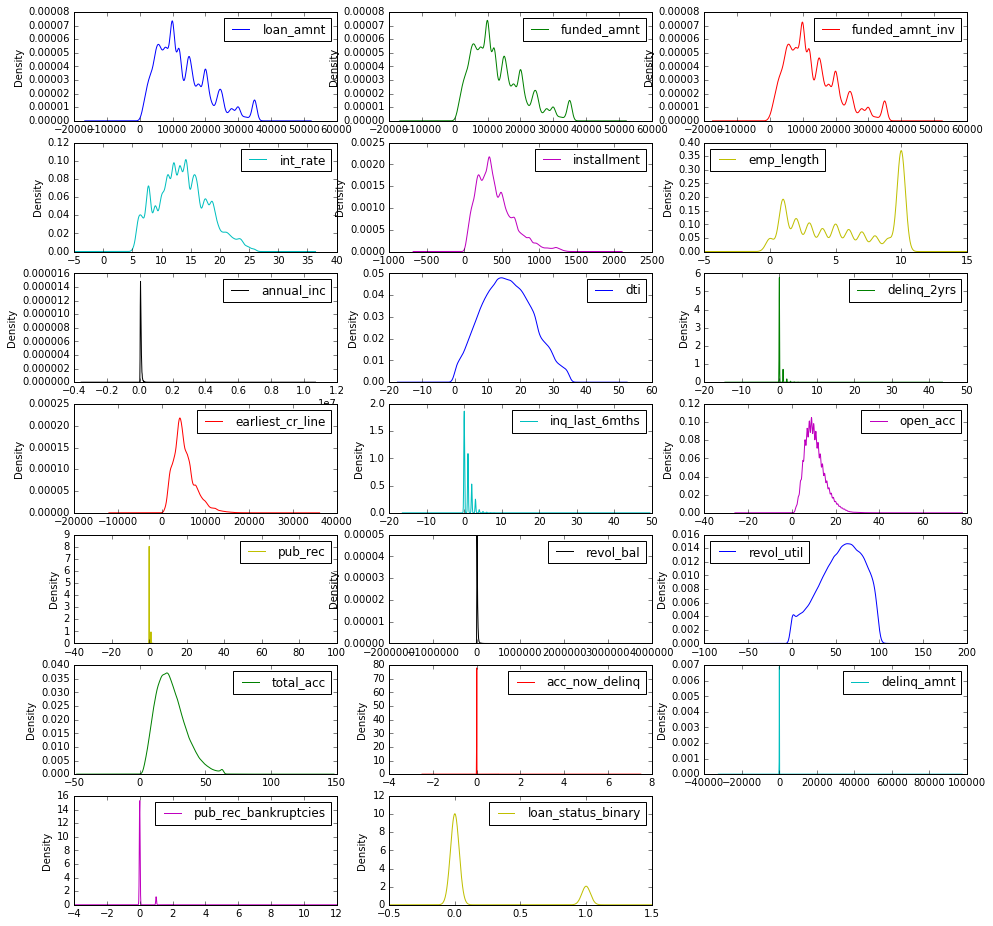

In [38]:
df.plot(kind='density', subplots=True, layout=(7,3), sharex=False, figsize=(16,16) )
plt.show()

** and the box plots for the same variables**

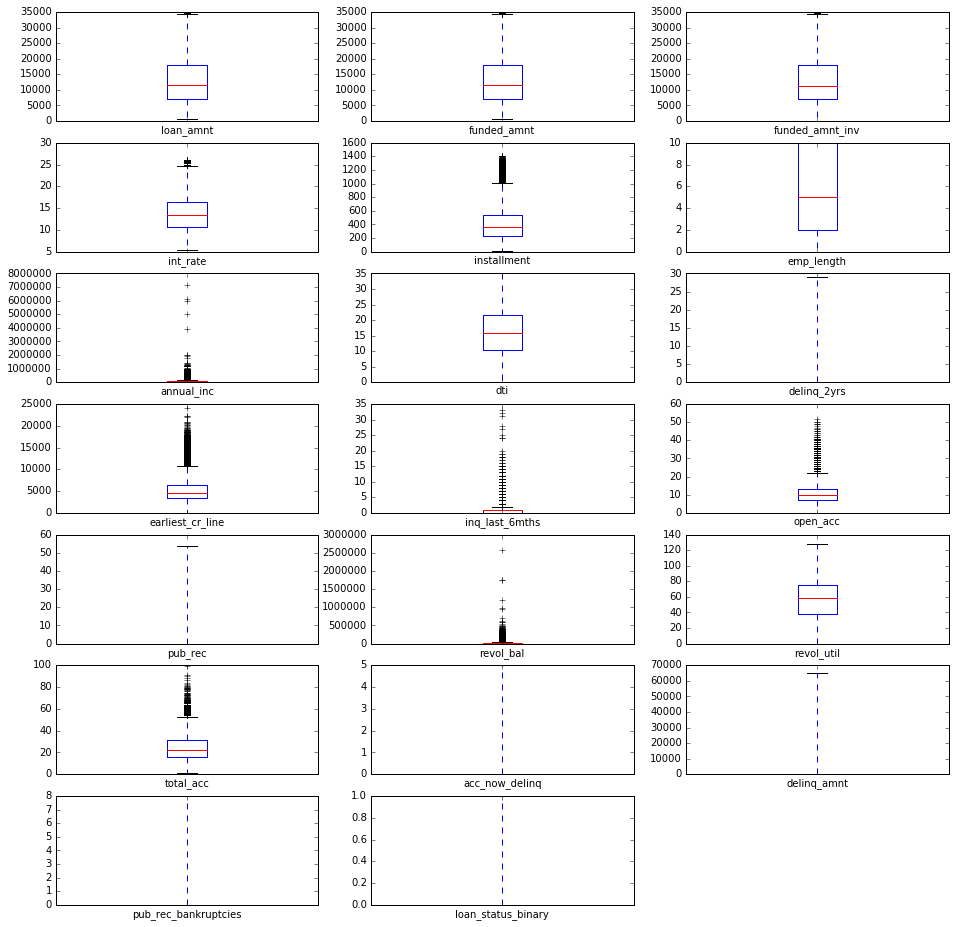

In [39]:
df.plot(kind='box', subplots=True, layout=(7,3), sharex=False, sharey=False, figsize=(16,16) )
plt.show()

**loan_amnt, funded_amnt, funded_amnt_inv, installment show some right skewness. I could correct for this by transforming this variables to their logs, which would then give me a more Gaussian distribution.
int_rate, dti, show a more or less Gaussian distribution.
annual_inc, delinq_2yrs, revol_bal, an delinq_amnt have a very narrow range  with a mean of about 0. These features might not be very useful for modeling**

<br>
### An analysis of the categorical data

**How does the default rate vary bteween repayment terms?**

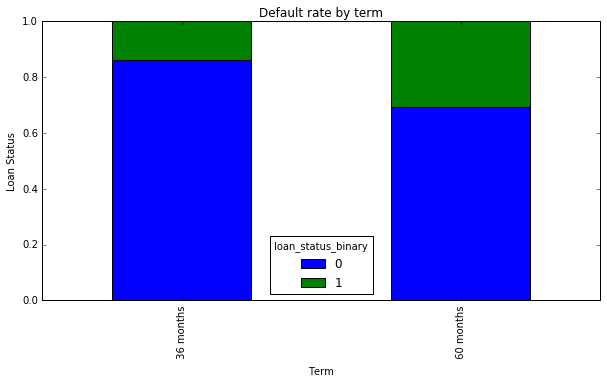

In [40]:
term_status = pd.crosstab(df.term, df.loan_status_binary)
term_status = term_status.div(term_status.sum(1).astype(float), axis=0)


term_status.plot(kind='bar', stacked=True, title='Default rate by term', figsize=(10,5))
plt.xlabel('Term')
plt.ylabel('Loan Status')

The plot shows that there is a higher default rate for borrowers with a 60-month repayment term as compared to a 36-month term. This makes the term feature a desirable feature for predictive modeling

<br>
**Interest rates are based on the credit worthiness of the borrower. In a sense therefore, one would expect higher interests rates to be tied to bad loans as compared to good ones (we have already seen a signficant difference in the interest rates distributions for good and bad loans).**

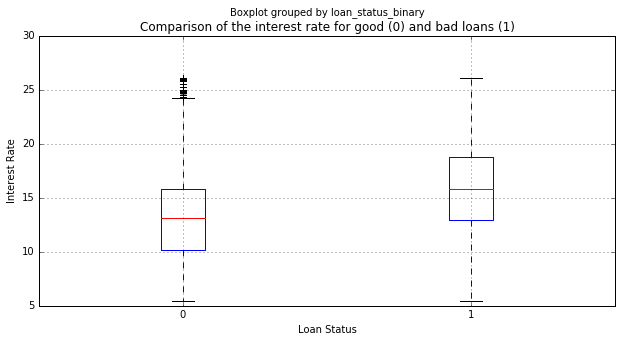

In [43]:
df.boxplot(column="int_rate",by="loan_status_binary", figsize=(10,5))
plt.xlabel('Loan Status')
plt.ylabel('Interest Rate')
plt.title('Comparison of the interest rate for good (0) and bad loans (1)')

As expected, the bad loans have a higher mean interest rate as compared to the good loans.

<br>
**How about employment length? How useful is this feature in a predictive model? Do we see a significant difference in employment length between the good and bad loans?**

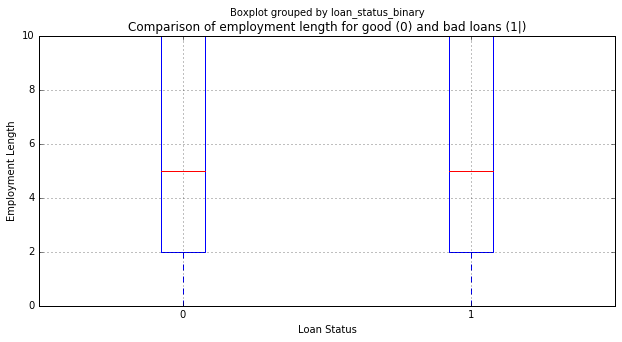

In [44]:
df.boxplot(column="emp_length",by="loan_status_binary", figsize=(10,5))
plt.xlabel('Loan Status')
plt.ylabel('Employment Length')
plt.title('Comparison of employment length for good (0) and bad loans (1|)')

The loan status does not seem to be strongly dependent on the length of employment and therefore this feature is unlikely to be very useful in a predictive model.

<br>
**Let us investigate the home ownership feature usefulness in a predictive model**

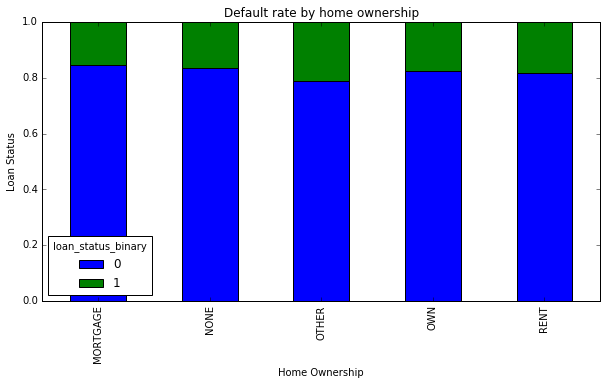

In [45]:
home_ownship = pd.crosstab(df.home_ownership, df.loan_status_binary)
home_ownship = home_ownship.div(home_ownship.sum(1).astype(float), axis=0)


home_ownship.plot(kind='bar', stacked=True, title='Default rate by home ownership', figsize=(10,5))
plt.xlabel('Home Ownership')
plt.ylabel('Loan Status')

There does not seem to be a significant difference in the status of a loan based on home ownership

**According to the Lending Club investor notes, loans that have been income verified performance similarly to loans that have not been income verified. Let us see what the plots tell us**

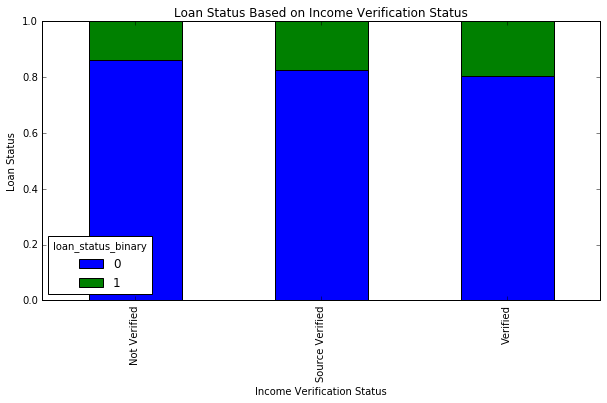

In [46]:
verif_status = pd.crosstab(df.verification_status, df.loan_status_binary)
verif_status = verif_status.div(verif_status.sum(1).astype(float), axis=0)


verif_status.plot(kind='bar', stacked=True, title='Loan Status Based on Income Verification Status', figsize=(10,5))
plt.xlabel('Income Verification Status')
plt.ylabel('Loan Status')

Income verification does not seem to be a good predictor of the likelihood of a loan default.

<br>
**Would the stated purpose of a loan help in predicting the likelihood of a loan default?**

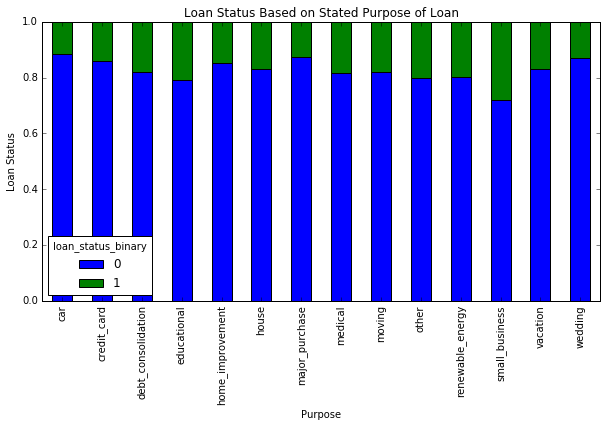

In [47]:
purpose = pd.crosstab(df.purpose , df.loan_status_binary)
purpose = purpose.div(purpose.sum(1).astype(float), axis=0)


purpose.plot(kind='bar', stacked=True, title='Loan Status Based on Stated Purpose of Loan', figsize=(10,5))
plt.xlabel('Purpose')
plt.ylabel('Loan Status')

Those who indicated that the reason for taking out a loan is for small business are more likely to default on a loan, and so are those who stated the purpose as educational. On the filp-side, those borrowing money for a major purchase or for a car are less likely to default.

<br>
**Are there borrowers from certain states that show a greater tendency to default on their loans?**

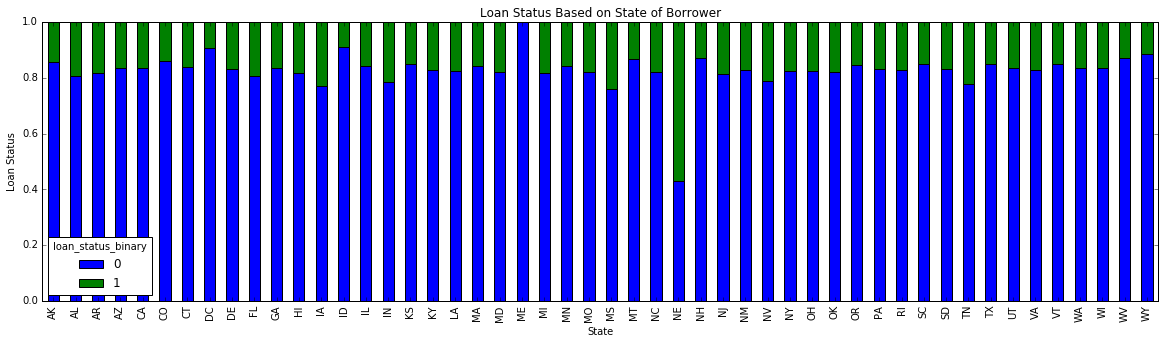

In [48]:
state = pd.crosstab(df.addr_state , df.loan_status_binary)
state = state.div(state.sum(1).astype(float), axis=0)


state.plot(kind='bar', stacked=True, title='Loan Status Based on State of Borrower', figsize=(20,5))
plt.xlabel('State')
plt.ylabel('Loan Status')

Based on the above plot, it seems that borrowers from the states of Nebraska and Indiana tend to default on their loans at rates higher than borrowers from other states. These figure though might not tell the whole story since we only have 11 borrowers from Nebraska as compared to, say 7432 from California, and its therefore not safe to draw any hard conclusions from the plot.

<br>
**Dummy encoding for categorical data**

In [49]:
#First, drop column on addr_state
df.drop(['addr_state'], axis=1, inplace=True)

#Get categorical columns
cat_col = df.columns[df.dtypes==object] 

#Create dummy variables
df_dummy = pd.get_dummies(df[cat_col]) 

#Drop categorical columns already encoded
df.drop(cat_col, axis=1, inplace=True) 

#Join the dummy variables to original dataframe
df = df.join(df_dummy) 

**Addressing multicollinearity**

In [50]:
corrmatrix = df.corr().abs()
corrmatrix = corrmatrix.stack()
corrmatrix[(corrmatrix > 0.6) & (corrmatrix != 1.0)].sort_values(ascending=True)

verification_status_Verified      verification_status_Not Verified    0.639063
verification_status_Not Verified  verification_status_Verified        0.639063
total_acc                         open_acc                            0.672061
open_acc                          total_acc                           0.672061
pub_rec_bankruptcies              pub_rec                             0.791670
pub_rec                           pub_rec_bankruptcies                0.791670
home_ownership_RENT               home_ownership_MORTGAGE             0.849643
home_ownership_MORTGAGE           home_ownership_RENT                 0.849643
installment                       funded_amnt_inv                     0.951947
funded_amnt_inv                   installment                         0.951947
installment                       loan_amnt                           0.956760
loan_amnt                         installment                         0.956760
funded_amnt                       installment       

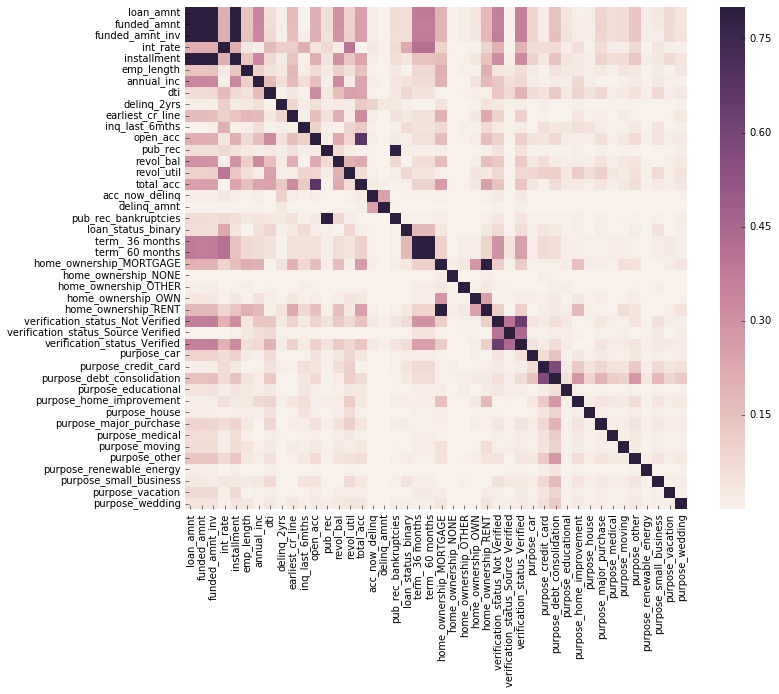

In [51]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df.corr().abs(), vmax=.8, square=True)

<br>
### A note on highly correlated features

<font color='red'>**I will be addressing highly correlated variables in part II**</font>

**This are the final selected columns we will model on**

In [52]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190040 entries, 0 to 190039
Data columns (total 44 columns):
loan_amnt                              190040 non-null float64
funded_amnt                            190040 non-null float64
funded_amnt_inv                        190040 non-null float64
int_rate                               190040 non-null float64
installment                            190040 non-null float64
emp_length                             190040 non-null int64
annual_inc                             190040 non-null float64
dti                                    190040 non-null float64
delinq_2yrs                            190040 non-null float64
earliest_cr_line                       190040 non-null float64
inq_last_6mths                         190040 non-null float64
open_acc                               190040 non-null float64
pub_rec                                190040 non-null float64
revol_bal                              190040 non-null float64
revol_uti

** Loan_status_binary contains our labels with two classes, 0 and 1**

In [53]:
df.loan_status_binary.value_counts()

0    157814
1     32226
Name: loan_status_binary, dtype: int64

As you can see, the two classes are imbalanced. This something that can potentially skew the prediction model and will need to be addressed either by oversampling the minority class, undersampling the majority class, or a combination of both. Applying weights during the modeling process might also help in countering the imbalance.

<br>
** Re-order the columns so that the loan_status_binary column (labels) is first. This will make it easier to select the labels **

In [54]:
columns = list(df.columns.values)
temp = columns[0]
columns[0] = columns[19]
columns[19] = temp
df = df[columns]

<br>
**Pickle the cleaned dataframe to allow for faster loading. In part II, I will use this as a starting point for model building by loading the pickled file**

In [ ]:
df.to_pickle('df_20072013_clean.pkl')

<br>
### <font color='Navy'>In part II of building a loan default predictive model, I will cover model building and evaluation, as well as explore a few Machine Learning algorithms.</font>